In [4]:
import json
import os
from matplotlib import pyplot as plt
import pandas as pd


In [5]:

# open all.json
os.system("wget -r https://epic.gsfc.nasa.gov/api/enhanced/all")
os.rename("epic.gsfc.nasa.gov/api/enhanced/all", "epic.gsfc.nasa.gov/api/enhanced/all.json")


--2025-02-01 13:28:47--  https://epic.gsfc.nasa.gov/api/enhanced/all
Resolving epic.gsfc.nasa.gov (epic.gsfc.nasa.gov)... 2001:4d0:2310:170::112, 129.164.142.112
Connecting to epic.gsfc.nasa.gov (epic.gsfc.nasa.gov)|2001:4d0:2310:170::112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘epic.gsfc.nasa.gov/api/enhanced/all’

     0K .......... .......... .......... .......... ..........  216K
    50K .......... .......... .......... .......... ..........  437K
   100K .......... .......... .......... .......... .......... 73.0M
   150K .......... .......... .......... .......... ..........  434K
   200K .......... .......... .......... .......... ..........  138M
   250K .......... .......... ..........                        220M=0.5s

2025-02-01 13:28:48 (607 KB/s) - ‘epic.gsfc.nasa.gov/api/enhanced/all’ saved [286947]

FINISHED --2025-02-01 13:28:48--
Total wall clock time: 1.5s
Downloaded: 1 files, 280K in 0.5s (607

In [6]:

def contruct_date_list(): 
    dates = []
    with open("epic.gsfc.nasa.gov/api/enhanced/all.json") as f:
        data = json.load(f)
        for d in data:
            dates.append(d["date"])
    return dates

dates = contruct_date_list()
            
image_folders = []
# construct all image folder urls
for d in dates:
    image_folders.append(f"https://epic.gsfc.nasa.gov/api/enhanced/date/{d}")
print(len(image_folders))
print(len(dates))
print(image_folders[0])


13043
13043
https://epic.gsfc.nasa.gov/api/enhanced/date/2025-01-29


# PLEASE REMOVE DUPLICATES !!!!!111!!!11!1!1! Danger Below

In [ ]:
# make all image folders
''' os.system("mkdir images")
for i in range(len(dates)):
    os.system(f"mkdir images/{dates[i]}")
    os.system(f"wget -P images/{dates[i]} {image_folders[i]}")
    os.system(f"mv images/{dates[i]}/{dates[i]} images/{dates[i]}/{dates[i]}.json") '''


In [7]:
folders = os.listdir("images")
folders.sort()
if ".DS_Store" in folders:
    folders.remove(".DS_Store")
len(folders)
for i in range(len(folders)):
    os.system(f"cp images/{folders[i]}/{folders[i]}.json combined")


In [8]:
files = os.listdir("combined")
if ".DS_Store" in files:
    files.remove(".DS_Store")
print(files)

['2016-07-22.json', '2022-04-11.json', '2020-11-18.json', '2019-01-21.json', '2020-03-25.json', '2018-09-05.json', '2017-01-18.json', '2017-03-25.json', '2017-11-18.json', '2018-05-26.json', '2023-10-16.json', '2021-07-22.json', '2020-12-08.json', '2022-07-01.json', '2016-08-11.json', '2017-02-08.json', '2018-08-28.json', '2023-03-06.json', '2021-08-11.json', '2017-12-08.json', '2020-07-31.json', '2022-10-05.json', '2017-07-31.json', '2015-10-05.json', '2023-04-02.json', '2023-08-21.json', '2020-08-02.json', '2022-03-15.json', '2022-01-28.json', '2016-10-26.json', '2019-04-18.json', '2019-06-25.json', '2022-11-28.json', '2020-04-21.json', '2015-11-28.json', '2017-04-21.json', '2018-12-22.json', '2023-07-12.json', '2021-10-26.json', '2018-02-22.json', '2022-10-13.json', '2020-07-27.json', '2019-05-23.json', '2016-03-20.json', '2021-03-20.json', '2018-01-24.json', '2018-03-19.json', '2023-06-29.json', '2023-04-14.json', '2015-10-13.json', '2017-07-27.json', '2018-11-24.json', '2020-08-14

Text(0.5, 0, 'Longitude in °')

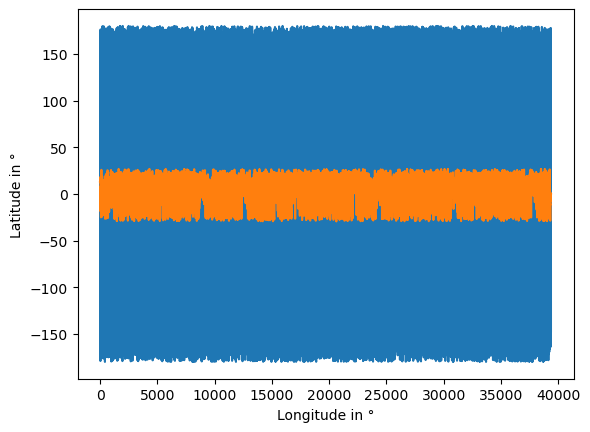

In [10]:
lat_coordinates = []
lon_coordinates = []
for i in range(len(files)):
    with open(f"combined/{files[i]}") as f:
        data = json.load(f)
        for p in range(len(data)):
            lat_coordinates.append(data[p]["centroid_coordinates"]["lat"])
            lon_coordinates.append(data[p]["centroid_coordinates"]["lon"])

plt.plot(lon_coordinates)
plt.plot(lat_coordinates)
plt.ylabel("Latitude in °")
plt.xlabel("Longitude in °")

        

In [ ]:
df_lat = pd.DataFrame(lat_coordinates)
df_lon = pd.DataFrame(lon_coordinates)
print("lat describe: ")
print(df_lat.describe())
print("---------------")
print("lon describe: ")
print(df_lon.describe())

In [ ]:
# make distribution of lat and lon
plt.hist(lon_coordinates, bins=100, label="longitude in ° (breite 0° = greenwich)")
plt.ylabel("Frequency")
plt.hist(lat_coordinates, bins=100, label="latitude in ° (höhe über dem äquator)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


![Explanation for you <3](https://s3.us-east-2.amazonaws.com/journeynorth.org/images/graphics/mclass/Lat_Long.gif)